In [1]:
from model.afnonet import AFNONet

In [2]:
import os 
import torch

$$
\left(
\begin{array}{ccccccc}
 \epsilon _{\text{II}}^1-\epsilon _{\text{II}}^{\text{real}} & 0 & 0 & 0 & 0 & 0 & 0 \\
 \epsilon _{\text{III}}^2-\epsilon _{\text{III}}^{\text{real}} & \epsilon _{\text{III}}^1-\epsilon _{\text{III}}^{\text{real}} & 0 & 0 & 0 & 0 & 0 \\
 \epsilon _{\text{IV}}^3-\epsilon _{\text{IV}}^{\text{real}} & \epsilon _{\text{IV}}^2-\epsilon _{\text{IV}}^{\text{real}} & \epsilon _{\text{IV}}^1-\epsilon _{\text{IV}}^{\text{real}} & 0 & 0 & 0 & 0 \\
 \epsilon _V^4-\epsilon _V^{\text{real}} & \epsilon _V^3-\epsilon _V^{\text{real}} & \epsilon _V^2-\epsilon _V^{\text{real}} & \epsilon _V^1-\epsilon _V^{\text{real}} & 0 & 0 & 0 \\
 \epsilon _{\text{VI}}^5-\epsilon _{\text{VI}}^{\text{real}} & \epsilon _{\text{VI}}^4-\epsilon _{\text{VI}}^{\text{real}} & \epsilon _{\text{VI}}^3-\epsilon _{\text{VI}}^{\text{real}} & \epsilon _{\text{VI}}^2-\epsilon _{\text{VI}}^{\text{real}} & \epsilon _{\text{VI}}^1-\epsilon _{\text{VI}}^{\text{real}} & 0 & 0 \\
 \epsilon _{\text{VII}}^6-\epsilon _{\text{VII}}^{\text{real}} & \epsilon _{\text{VII}}^5-\epsilon _{\text{VII}}^{\text{real}} & \epsilon _{\text{VII}}^4-\epsilon _{\text{VII}}^{\text{real}} & \epsilon _{\text{VII}}^3-\epsilon _{\text{VII}}^{\text{real}} & \epsilon _{\text{VII}}^2-\epsilon _{\text{VII}}^{\text{real}} & \epsilon _{\text{VII}}^1-\epsilon _{\text{VII}}^{\text{real}} & 0 \\
 \epsilon _{\text{VIII}}^7-\epsilon _{\text{VIII}}^{\text{real}} & \epsilon _{\text{VIII}}^6-\epsilon _{\text{VIII}}^{\text{real}} & \epsilon _{\text{VIII}}^5-\epsilon _{\text{VIII}}^{\text{real}} & \epsilon _{\text{VIII}}^4-\epsilon _{\text{VIII}}^{\text{real}} & \epsilon _{\text{VIII}}^3-\epsilon _{\text{VIII}}^{\text{real}} & \epsilon _{\text{VIII}}^2-\epsilon _{\text{VIII}}^{\text{real}} & \epsilon _{\text{VIII}}^1-\epsilon _{\text{VIII}}^{\text{real}} \\
\end{array}
\right)
$$

$$ 
f (X_t)+\epsilon_I^t=\hat{X_{t+1}} + \epsilon_I^t = X_{t+1}
$$

$$
f[f(X_t)] + \epsilon_{II}^t = X_{t+2}\\
f (X_{t+1})+\epsilon_I^{t+1}=\hat{X_{t+2}} + \epsilon_I^{t+1} = X_{t+2}
$$


$$
\epsilon_{II}^t = f (X_{t+1}) - f[f(X_t)]  +\epsilon_I^{t+1} = f (X_{t+1}) - f[\hat{X_{t+1}}]+\epsilon_I^{t+1}
$$

$$
\epsilon_{II}^t = \nabla f|_{X_{t+1}} [X_{t+1}-\hat{X_{t+1}}]+\epsilon_I^{t+1} =  \nabla f|_{X_{t+1}} \epsilon_I^{t} +\epsilon_I^{t+1}
$$

In [3]:
import numpy as np

In [4]:
def get_list_of_N(N):
    _list = []
    for i in range(N):
        start = i
        temp  = [start]
        if i>0:
            for j in range(i):
                temp.append(start+N-1-j)  
                start = start+N-1-j
        temp.reverse()
        _list+=temp
    return _list

In [5]:
map_total_num_to_N    = {}
map_total_num_to_list = {}
for N in range(6,22):
    _list = get_list_of_N(N)
    map_total_num_to_N[len(_list)] = N
    map_total_num_to_list[len(_list)] = _list

In [6]:
def get_error_propagation(fourcastresult):
#     error_order7 = torch.LongTensor([  0,
#                                        7, 1,
#                                       13, 8, 2,
#                                       18,14, 9, 3,
#                                       22,19,15,10,4,
#                                       25,23,20,16,11,5,
#                                       27,26,24,21,17,12,6])
#     error_order6 = torch.LongTensor([ 0,
#                                       6, 1,
#                                      11, 7, 2,
#                                      15,12, 8, 3,
#                                      18,16,13, 9,4,
#                                      20,19,17,14,10,5
#                                     ])
    idxkeys=[t for t in fourcastresult.keys() if isinstance(t,int)]
    idxkeys.sort()
    out={}
    for key in ['error_record','real_res_error_record', 'real_appx_delta_record','appx_res_error_record']:
        b = []
        total_length = len(fourcastresult[0][key])
        N=map_total_num_to_N[total_length];
        x,y = torch.tril_indices(N,N)
        error_order = map_total_num_to_list[total_length]
        for i in idxkeys:
            a = torch.zeros(N,N,70)
            a[x,y] = fourcastresult[i][key][error_order]
            b.append(a)
        b = torch.stack(b)
        out[key] = b
    for key in ['real_res_angle_record','appx_res_angle_record']:
        b = []
        total_length = len(fourcastresult[0][key])
        N=map_total_num_to_N[total_length];
        x,y = torch.tril_indices(N,N)
        error_order = map_total_num_to_list[total_length]
        for i in idxkeys:
            a = torch.zeros(N,N)
            a[x,y] = fourcastresult[i][key][error_order]
            b.append(a)
        b = torch.stack(b)
        out[key] = b
#     for key in ['abs_error', 'est_error', 'Jacobianv', 'JacobV_N','abc_error']:
#         b = []
#         for i in range(len(fourcastresult)-10):
#             a = torch.zeros(N,N)
#             a[x,y] = fourcastresult[i][key][error_order]
#             if key != 'JacobV_N':a=a/fourcastresult[i]['blevel_v'].mean(1)[1:,None]
#             b.append(a)
#         b = torch.stack(b)
#         out[key] = b
    
#     for key in ['Angle']:
#         b = []
#         for i in range(len(fourcastresult)-10):
#             a = torch.zeros(N,N)
#             a[x,y] = fourcastresult[i][key][error_order]
#             b.append(a)
#         b = torch.stack(b)
#         out[key] = b
        
#     for key in ['alevel_v','blevel_v','JacobVA_N']:
#         b = []
#         for i in range(len(fourcastresult)-10):
#             b.append(fourcastresult[i][key])
#         b = torch.stack(b)
#         out[key] = b
    return out

In [7]:
def get_fourcastresult(fourcastresult):
    #fourcastresult="checkpoints/WeathBench7066/AFNONet/ts_2_pretrain-2D706N_per_1_step/01_06_12_22-seed_73001"
    ROOT= fourcastresult
    fourcastresult_list = [os.path.join(ROOT,p) for p in os.listdir(fourcastresult) if 'fourcastresult.gpu' in p]
    fourcastresult={}
    for save_path in fourcastresult_list:
        tmp = torch.load(save_path)
        for key,val in tmp.items():
            if key not in fourcastresult:
                fourcastresult[key] = val
            else:
                if key == 'global_rmse_map':

                    fourcastresult['global_rmse_map'] = [a+b for a,b in zip(fourcastresult['global_rmse_map'],tmp['global_rmse_map'])]
                else:
                    fourcastresult[key] = val # overwrite
    return fourcastresult

In [5]:
# fourcastresult_pretrain="checkpoints/WeathBench7066/AFNONet/ts_2_pretrain-2D706N_per_1_step/01_06_12_22-seed_73001"
# fourcastresult_pretrain = get_fourcastresult(fourcastresult_pretrain)
# # torch.save(fourcastresult_pretrain,fourcastresult+"/fourcastresult.mid_tangent.pt")
# fourcastresult_finetune="checkpoints/WeathBench7066/AFNONet/ts_3_finetune-2D706N_per_1_step/01_09_02_41_31-seed_73001"
# fourcastresult_finetune = get_fourcastresult(fourcastresult_finetune)
# #torch.save(fourcastresult_finetune,fourcastresult+"/fourcastresult.right_tangent.pt")

In [8]:
fwd1times_sketch     = get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_2_pretrain-2D706N_per_1_step/01_26_14_21_64252-seed_73001"))
fwd2times_pretrain   = get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_3_finetune-2D706N_per_1_step/01_26_17_38_64254-seed_73001"))
fwd2times_sketch     = get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_3_pretrain-2D706N_per_1_step/01_26_23_35_64256-seed_73001"))
fwd3times_pretrain   = get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_4_finetune-2D706N_per_1_step/01_26_23_56_64255-seed_73001"))
fwd3times_sketch     = get_error_propagation(get_fourcastresult("checkpoints/WeathBench7066/AFNONet/ts_4_pretrain-2D706N_per_1_step/01_26_17_38_64248-seed_73001"))

In [9]:
import torch

In [10]:
from mltool.visualization import *

In [11]:
_component_list= ([58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,  1]+ # u component of wind and the 10m u wind
                    [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,  2]+   # v component of wind and the 10m v wind
                    [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  0]+   # Temperature and the 2m_temperature
                    [ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 18]+   # Geopotential and the last one is ground Geopotential, should be replace later
                    [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 57]    # Realitve humidity and the Realitve humidity at groud, should be modified by total precipitaiton later
                    )
single_vnames = ["2m_temperature",
                  "10m_u_component_of_wind",
                  "10m_v_component_of_wind",
                  "total_cloud_cover",
                  "total_precipitation",
                  "toa_incident_solar_radiation"]
level_vnames= []
for physics_name in ["geopotential", "temperature",
                     "specific_humidity","relative_humidity",
                     "u_component_of_wind","v_component_of_wind",
                     "vorticity","potential_vorticity"]:
    for pressure_level in [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]:
        level_vnames.append(f"{pressure_level}hPa_{physics_name}")
all_vnames = single_vnames + level_vnames
vnames= np.array([all_vnames[i] for i in _component_list])
vnames[14*4-1] = 'pad1'
vnames[-1]='pad2'

In [12]:
data_list = [
fwd1times_sketch  ,
fwd2times_sketch  ,
fwd2times_pretrain,
fwd3times_sketch  ,
fwd3times_pretrain,    
]
name_list = [
"fwd1times_sketch"  ,
"fwd2times_sketch"  ,
"fwd2times_pretrain",
"fwd3times_sketch"  ,
"fwd3times_pretrain"
]

In [13]:
upsign = ['I','II','III','IV','V','VI','VII','VIII']

### plot

In [122]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')
# error_matrix      = data_list[4]['error_record']
# colorlist=['r','g','b','pink','black','yellow']
# plt.figure(figsize=(10,6))

# with plt.style.context(['science', 'no-latex', 'nature']):
#     for level in range(7):
#         data = error_matrix[:,level,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,label=r"$||\epsilon^"+f"{level}"+r"||$")
#         plt.xticks(x_axis,vnames,rotation = 90) 
#         plt.legend(prop={'size': 14})
#         ax = plt.gca()
#         plt.text(.5,.9,'fwd3times_pretrain',horizontalalignment='center',
#             transform=ax.transAxes,fontdict={'size':30})

In [135]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','pink','black','yellow']
# plt.figure(figsize=(10,6))
# level=4
# with plt.style.context(['science', 'no-latex', 'nature']):
#     for name,tdata in zip(name_list,data_list):
#         data = tdata['error_record'][:,level,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,label=name)
#         plt.xticks(x_axis,vnames,rotation = 90) 
#         plt.legend(prop={'size': 14})
#         ax = plt.gca()
#         plt.text(.5,.9,r"$|| \epsilon^{"+f"{upsign[level]}"+r"} ||$",horizontalalignment='center',transform=ax.transAxes,fontdict={'size':30})

In [137]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')
# dataidx = 4
# error_matrix      = data_list[dataidx]['real_res_error_record']
# colorlist=['r','g','b','pink','black','yellow']
# plt.figure(figsize=(10,6))
# upsign = ['I','II','III','IV','V','VI','VII','VIII']
# with plt.style.context(['science', 'no-latex', 'nature']):
#     for level in range(6):
#         data = error_matrix[:,level,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,
#                      label=r"$||\epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+2]}"+r"} - \epsilon_{t+"+f"{level+2}"+"}^I||$ = $||M \epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+1]}"+r"}||$"
#                     )
#         plt.legend(prop={'size': 12})
# #        plt.xticks(x_axis,vnames,rotation = 90) 
#         ax = plt.gca()
#         plt.text(.5,.9,name_list[dataidx],horizontalalignment='center',
#             transform=ax.transAxes,fontdict={'size':13})

In [139]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','pink','black','yellow']
# plt.figure(figsize=(10,6))
# level = 5
# with plt.style.context(['science', 'no-latex', 'nature']):
#     for name,tdata in zip(name_list,data_list):
#         data = tdata['real_res_error_record'][:,level,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,label=name)
#         plt.xticks(x_axis,vnames,rotation = 90) 
#         plt.legend(prop={'size': 14})
#         ax = plt.gca()
#         plt.text(.5,.9,r"$||\epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+2]}"+r"} - \epsilon_{t+"+f"{level+2}"+"}^I||$ = $||M \epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+1]}"+r"}||$",
#                  horizontalalignment='center',transform=ax.transAxes,fontdict={'size':14})

In [141]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','pink','black','yellow']
# plt.figure(figsize=(10,6))
# level = 0
# with plt.style.context(['science', 'no-latex', 'nature']):
#     for name,tdata in zip(name_list,data_list):
#         data = tdata['real_res_error_record'][:,level,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,label=name)
#         plt.xticks(x_axis,vnames,rotation = 90) 
#         plt.legend(prop={'size': 14})
#         ax = plt.gca()
#         plt.text(.5,.9,r" $||J|_{(\frac{1}{2}X_{t+"+f"{level+2}"+"}^O + \\frac{1}{2}X_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+1]}"+r"})}\epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+1]}"+r"}||$",
#                  horizontalalignment='center',transform=ax.transAxes,fontdict={'size':14})

In [237]:
# %matplotlib inline
# colorlist=['r','g','b','pink','black','purple','olive']
# import scienceplots
# plt.style.use('science')
# with plt.style.context(['science', 'no-latex', 'nature']):
#     fig, axes = plt.subplots(5, 1,figsize=(10,6))
#     axes=axes.flatten()
#     level=0
#     for num,(ax,name,tdata) in enumerate(zip(axes,name_list,data_list)):
#         for level in range(6):
#             data = tdata['appx_res_error_record'][:,level,0]
#             mean = data.mean(0)
#             std  = data.std(0)
#             x_axis = np.arange(len(mean))
#             #plt.errorbar(x_axis, mean, yerr = std,label=name)
#             ax.plot(x_axis, mean, label=name+'_real',color = colorlist[level])
#             data = tdata['real_res_error_record'][:,level,0]
#             mean = data.mean(0)
#             std  = data.std(0)
#             x_axis = np.arange(len(mean))
#             ax.plot(x_axis, mean, label=name+'_appx',linestyle = ':',color = colorlist[level])
#         ax.set_ylim([0,0.08])
#         ax.set_xticklabels([])
#         ax.text(.5,.7,name,horizontalalignment='center',transform=ax.transAxes,fontdict={'size':10})
#         #ax.set_yticklabels([])
#         #ax.set_yscale('log')
#         if num == 0:ax.set_title("Error_Approx_Via_Jacobian",fontsize=20)
# plt.subplots_adjust(wspace=0, hspace=0)

In [239]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','pink','black','yellow']
# plt.figure(figsize=(10,6))
# level = 4
# with plt.style.context(['science', 'no-latex', 'nature']):
#     for offset,(name,tdata) in enumerate(zip(name_list,data_list)):
#         tdata_real_res_error_alpha = tdata['real_res_error_record']/(tdata['error_record'][:,:-1,:-1]+1e-10)
#         data = tdata_real_res_error_alpha[:,level,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,label=name)
#         plt.legend(prop={'size': 14})
#         plt.xticks(x_axis,vnames,rotation = 90) 
#         ax = plt.gca()
#         plt.text(.5,.9,r"$\frac{||\epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+2]}"+r"} - \epsilon_{t+"+f"{level+2}"+"}^I||}{||\epsilon_{t+"+f"{level+2}"+"}^{"+f"{upsign[level+1]}"+r"}||}$",
#                  horizontalalignment='center',transform=ax.transAxes,fontdict={'size':20})

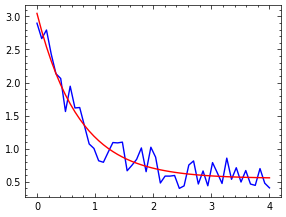

In [235]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

rng = np.random.default_rng()
y_noise = 0.2 * rng.normal(size=xdata.size)
ydata = y + y_noise
with plt.style.context(['science', 'no-latex', 'nature']):
    plt.plot(xdata, ydata, 'b-', label='data')
popt, pcov = curve_fit(func, xdata, ydata)
with plt.style.context(['science', 'no-latex', 'nature']):
    plt.plot(xdata, func(xdata, *popt), 'r-',
             label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

In [167]:
tdata = data_list[-1]
tdata_real_res_error_alpha = (tdata['real_res_error_record']).mean(-1)/(tdata['error_record'].mean(-1)[:,:-1,:-1]+1e-10)

fitdata = tdata_real_res_error_alpha[:,:,0].numpy().mean(0)

multiper = 1
valuelist= [1]
for alpha in fitdata:
    valuelist.append(1+alpha*(valuelist[-1]))
valuelist = np.array(valuelist)

error1 = tdata['error_record'].mean(-1)[:,0,0].mean().numpy()

fake_alpha=[0.378086, 0.459749, 0.530689, 0.592313, 0.645846, 0.69235, 0.732747, \
0.76784, 0.798325, 0.824806, 0.847811, 0.867795, 0.885155, 0.900235, \
0.913335, 0.924715, 0.9346, 0.943188]
multiper = 1
valuelist2= [1]
for alpha in fitdata:
    valuelist2.append(1+alpha*(valuelist2[-1]))
valuelist2 = np.array(valuelist2)

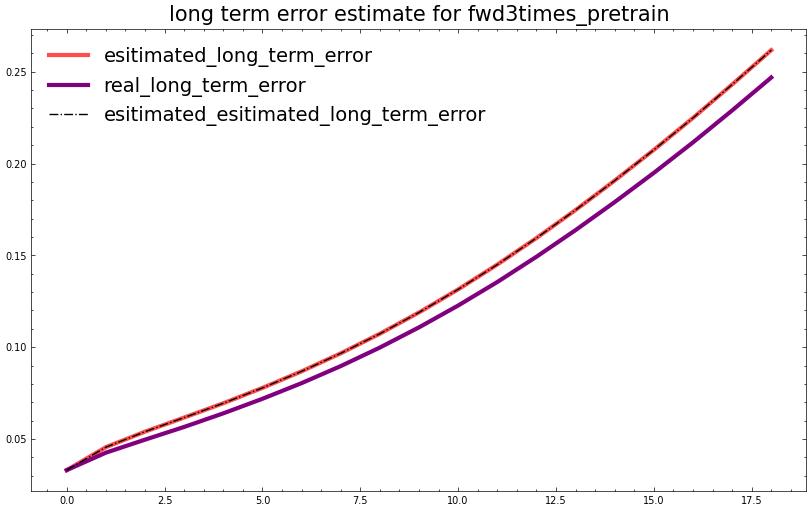

In [232]:
plt.figure(figsize=(10,6))
with plt.style.context(['science', 'no-latex', 'nature']):
    plt.plot(valuelist*error1,'r',label='esitimated_long_term_error',linewidth=3,alpha=0.7)
    plt.plot(tdata['error_record'].mean(-1)[:,:,0].mean(0),'purple',label='real_long_term_error',linewidth=3)
    plt.plot(valuelist2*error1,'black',label='esitimated_esitimated_long_term_error',linestyle='-.')
    plt.legend(prop={'size': 14})
    plt.title(f"long term error estimate for {name_list[-1]}",fontdict={'size':15})

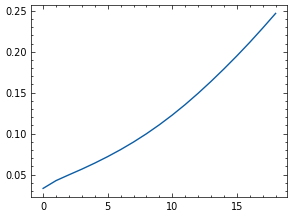

In [190]:
with plt.style.context(['science', 'no-latex', 'nature']):
    plt.plot(tdata['error_record'].mean(-1)[:,:,0].mean(0))

In [3]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots
def func(x, a, b):
    return 1 - a * np.exp(-b * x) 
# plt.style.use('science')

# colorlist=['r','g','b','olive','black','purple','pink']
# plt.figure(figsize=(10,6))
# level = 0
# with plt.style.context(['science', 'no-latex', 'nature']):
#     for offset,(name,tdata) in enumerate(zip(name_list,data_list)):
#         tdata_real_res_error_alpha = (tdata['real_res_error_record']).mean(-1)/(tdata['error_record'].mean(-1)[:,:-1,:-1]+1e-10)
#         data = tdata_real_res_error_alpha[:,:,0]
#         mean = data.mean(0).numpy()
#         print(",".join([str(t) for t in mean]))
#         a = 1 - mean[0]
#         b = np.log((1-mean[0])/(1-mean[1]))
#         x_axis = np.arange(len(mean))
#         plt.plot(x_axis, mean,label=name,marker='o',linestyle = 'None',color = colorlist[offset])
#         plt.plot(x_axis, func(x_axis,a,b),color = colorlist[offset])
#         plt.legend(prop={'size': 14})
#         plt.xticks(x_axis,[r"$\alpha^{"+f"{i}"+"}$" for i in range(len(x_axis))],fontsize=20)
#     ax = plt.gca()
#     plt.text(.2,.9,r"$\alpha^N=\frac{||\epsilon_{t+"+f"n"+"}^{"+f"N"+r"} - \epsilon_{t+"+f"n"+"}^I||}{||\epsilon_{t+"+f"n-1"+"}^{"+f"N-1"+r"}||}$",
#              horizontalalignment='center',transform=ax.transAxes,fontdict={'size':20})

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

colorlist=['r','g','b','olive','black','purple','pink']
plt.figure(figsize=(10,6))
level = 0
with plt.style.context(['science', 'no-latex', 'nature']):
    for offset,(name,tdata) in enumerate(zip(name_list,data_list)):
        tdata_real_res_error_alpha = (tdata['real_res_error_record']).mean(-1)/(tdata['error_record'].mean(-1)[:,:-1,:-1]+1e-10)
        data = tdata_real_res_error_alpha[:,:,0]
        mean = np.log(1-data.mean(0).numpy())
        x_axis = np.arange(len(mean))
        plt.plot(x_axis, mean,label=name,marker='o',color = colorlist[offset])
        plt.legend(prop={'size': 14})
        #plt.xticks(x_axis,[r"$\alpha^{"+f"{i}"+"}$" for i in range(len(x_axis))],fontsize=20)
    ax = plt.gca()
    plt.text(.3,.9,r"$\alpha^N=\frac{||\epsilon_{t+"+f"n"+"}^{"+f"N"+r"} - \epsilon_{t+"+f"n"+"}^I||}{||\epsilon_{t+"+f"n-1"+"}^{"+f"N-1"+r"}||}$",
             horizontalalignment='center',transform=ax.transAxes,fontdict={'size':20})

NameError: name 'name_list' is not defined

<Figure size 1000x600 with 0 Axes>

In [1]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','olive','black','purple','pink']
# plt.figure(figsize=(10,6))
# level = 0
# with plt.style.context(['science', 'no-latex', 'nature']):
#     for offset,(name,tdata) in enumerate(zip(name_list,data_list)):
#         tdata_real_res_error_alpha = (tdata['real_res_error_record']).mean(-1)/(tdata['error_record'].mean(-1)[:,:-1,:-1]+1e-10)
#         data = tdata_real_res_error_alpha[:,:,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.errorbar(x_axis, mean, yerr = std,label=name)
#         plt.legend(prop={'size': 14})
#         plt.xticks(x_axis,[r"$\alpha^{"+f"{i}"+"}$" for i in range(len(x_axis))],fontsize=20)
#     ax = plt.gca()
#     plt.text(.5,.9,r"$\frac{||\epsilon_{t+"+f"n"+"}^{"+f"N"+r"} - \epsilon_{t+"+f"n"+"}^I||}{||\epsilon_{t+"+f"n-1"+"}^{"+f"N-1"+r"}||}$",
#              horizontalalignment='center',transform=ax.transAxes,fontdict={'size':20})

In [241]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','olive','black','purple','pink']
# plt.figure(figsize=(10,6))
# level = 0
# with plt.style.context(['science', 'no-latex', 'ieee']):
#     for offset,(name,tdata) in enumerate(zip(name_list,data_list)):
#         tdata_real_res_error_alpha = (tdata['real_res_error_record']).mean(-1)/(tdata['error_record'].mean(-1)[:,:-1,:-1]+1e-10)
#         data = tdata_real_res_error_alpha[:,:,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.plot(x_axis, mean,label=name,linewidth=2, linestyle = '-',color = colorlist[offset])
#         tdata_real_res_error_alpha = (tdata['appx_res_error_record']).mean(-1)/(tdata['error_record'].mean(-1)[:,:-1,:-1]+1e-10)
#         data = tdata_real_res_error_alpha[:,:,0]
#         mean = data.mean(0)
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.plot(x_axis, mean,linestyle = ':',linewidth=2,color = colorlist[offset])
#         plt.legend(prop={'size': 14})
#         #plt.xticks(x_axis,[r"$\alpha^{"+upsign[i]+"}$" for i in range(6)],fontsize=20)
#         ax = plt.gca()
#         plt.text(.5,.1,"Error_Approx_Via_Jacobian", 
#                  horizontalalignment='center',transform=ax.transAxes,fontdict={'size':20})

In [162]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import scienceplots

# plt.style.use('science')

# colorlist=['r','g','b','olive','black','purple','pink']
# plt.figure(figsize=(10,6))
# level = 0
# with plt.style.context(['science', 'no-latex', 'ieee']):
#     for offset,(name,tdata) in enumerate(zip(name_list,data_list)):
#         tdata_real_res_error_alpha = torch.arccos(tdata['real_res_angle_record'])/np.pi*180
#         data = tdata_real_res_error_alpha[:,:,0]
#         mean = data.mean(0)[:6]
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.plot(x_axis, mean,label=name,linewidth=2, linestyle = '-',color = colorlist[offset])
#         tdata_real_res_error_alpha = torch.arccos(tdata['appx_res_angle_record'])/np.pi*180
#         data = tdata_real_res_error_alpha[:,:,0]
#         mean = data.mean(0)[:6]
#         std  = data.std(0)
#         x_axis = np.arange(len(mean))
#         plt.plot(x_axis, mean,linestyle = ':',linewidth=2,color = colorlist[offset])
#     plt.legend(prop={'size': 14})
#     #plt.xticks(x_axis,[r"$\theta^{"+upsign[i]+"}$" for i in range(6)],fontsize=20)
#     ax = plt.gca()
#     plt.text(.5,.6,"Error_Vertical_Via_Jacobian", 
#              horizontalalignment='center',transform=ax.transAxes,fontdict={'size':20})

### old M_iteration_method

In [157]:
# # property_index = 3
# # data = D3error[:,property_index]
# # name = D3name[property_index]
# # fig = plt.figure(figsize=(12,24))
# # _=plt.imshow(data)
# # _=plt.xticks(range(len(name)),name,rotation=-90)

# error_propagation_finetune['abc_error'].mean(0)

# error_propagation_pretrain['blevel_v'].mean(dim=(0,2))

# (np.arccos(error_propagation_pretrain['Angle'])/np.pi*180).mean(0)

# error_propagation_pretrain1 = get_error_propagation(fourcastresult_pretrain1)
# error_propagation_pretrain2 = get_error_propagation(fourcastresult_pretrain2)

# error_propagation_finetune1 = get_error_propagation(fourcastresult_finetune1)
# error_propagation_finetune2 = get_error_propagation(fourcastresult_finetune2)

# error_propagation_finetune1['est_error'].mean(0)

# error_propagation_finetune2['est_error'].mean(0)

# error_propagation_finetune1['abs_error'].mean(0)

# error_propagation_finetune2['abs_error'].mean(0)

# error_propagation_pretrain1['abs_error'].mean(0)

# error_propagation_pretrain2['abs_error'].mean(0)

# error_propagation_finetune1['JacobV_N'].mean(0).sqrt()

# error_propagation_finetune2['JacobV_N'].mean(0).sqrt()

# print(error_propagation_pretrain1['JacobVA_N'].mean(0).sqrt())
# print(error_propagation_pretrain2['JacobVA_N'].mean(0).sqrt())
# print(error_propagation_finetune1['JacobVA_N'].mean(0).sqrt())
# print(error_propagation_finetune2['JacobVA_N'].mean(0).sqrt())

# error_propagation_finetune2['JacobVA_N'].mean(0).sqrt()

# error_propagation_pretrain['alevel_v'].mean(0).sqrt()/error_propagation_finetune['blevel_v'].mean(0).sqrt()

# error_propagation_pretrain['Jacobianv'].mean(0)

# error_propagation_finetune['est_error'].mean(0)

# error_propagation_finetune['Jacobianv'].mean(0)

# error_propagation_finetune['est_error'].mean(0)*error_propagation_finetune['blevel_v'].mean(0)[:,None].sqrt()/error_propagation_pretrain['blevel_v'].mean(0)[:,None].sqrt()

# error_propagation_pretrain['blevel_v'].mean(0).sqrt()

# error_propagation_finetune['blevel_v'].mean(0).sqrt()

# x, y  = np.meshgrid(np.arange(7),np.arange(7))
# z = error_propagation_finetune['abs_error'].mean(0).numpy()
# data = np.stack([x,y,z],-1).reshape(-1,3)
# data = data[data[:,2]>0]

# weight = torch.load("checkpoints/WeathBench7066/AFNONet/time_step_2_pretrain-2D706N_every_1_step/10_14_20_18_11-seed_73001/backbone.best.pt", map_location='cpu')

# [k for k in weight['model'] if 'patch_embed.proj' in k]

# error_propagation_finetune['JacobV_N'].mean(0)

# error_propagation_pretrain['Jacobianv'].mean(0)

### res

In [35]:
model = AFNONet(img_size=(32,64), patch_size=2, in_chans= 70 ,out_chans= 70 ,embed_dim=768,depth=12)
# x = torch.randn(2,70,32,64)
# y = torch.randn(2,70,32,64)
# torch.save(model.state_dict(),"debug/testmodel.pt")
# torch.save(x,"debug/testx.pt")
# torch.save(y,"debug/testy.pt")
model.load_state_dict(torch.load("debug/testmodel.pt"))
x = torch.load("debug/testx.pt")
y = torch.load("debug/testy.pt")

In [42]:
class NGmod_RotationDeltaX(Nodal_GradientModifier):
    def normed(self,a):
        shape = a.shape
        a = a.reshape(a.size(0),-1)
        a = a/a.norm(dim=1,keepdim=True)
        a = a.reshape(shape)
        return a 

    def getRotationDeltaloss(self, modelfun, x,  t , rotation_regular_mode = '0y0'):
        y = model(x)
        if rotation_regular_mode =='0y0':
            delta = (self.normed(y - x),)
        elif rotation_regular_mode =='0v0':
            delta = (self.normed(y.detach() - x),)
        elif rotation_regular_mode =='Yy0':
            delta = (self.normed(t - x),self.normed(y - x))
        elif rotation_regular_mode =='Yv0':
            delta = (self.normed(t - x),self.normed(y.detach() - x))
        elif rotation_regular_mode =='YyN':
            delta = (self.normed(t - x),self.normed(y - x),self.normed(torch.rand_like(x)))
        else:
            raise NotImplementedError
        penalty= 0
        for delta_cons in delta:
            grad = functorch.jvp(modelfun, (x,), (delta_cons,))[1] 
            position_range = list(range(1,len(grad.shape))) # (B,P, W,H ) --> (1,2,3)
            penalty       += ((torch.sum(grad**2,dim=position_range).sqrt()-1)**2).mean()
        return penalty

    def getL2loss(self,modelfun,x,chunk=10,coef=None):
        raise
    def getL1loss(self,modelfun,x,chunk=10,coef=None):
        raise

In [8]:
from einops.layers.torch import Rearrange

In [9]:
import torch.nn as nn

In [10]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(30,30)
    def forward(self,x):
        x = self.linear(x)
        x = torch.sigmoid(x)
        x = x**2
        return x
model = MyModel()
torch.save(model.state_dict(),"debug/testmodel2.pt")
x = torch.randn(2,30)
y = torch.randn(2,30)
torch.save(x,"debug/testx2.pt")
torch.save(y,"debug/testy2.pt")

In [11]:
model = AFNONet(img_size=(32,64), patch_size=2, in_chans= 70 ,out_chans= 70 ,embed_dim=768,depth=12)
# x = torch.randn(2,70,32,64)
# y = torch.randn(2,70,32,64)
# torch.save(model.state_dict(),"debug/testmodel.pt")
# torch.save(x,"debug/testx.pt")
# torch.save(y,"debug/testy.pt")
model.load_state_dict(torch.load("debug/testmodel.pt"))
x = torch.load("debug/testx.pt")
y = torch.load("debug/testy.pt")
ngmod = NGmod_RotationDeltaX(0,0,0 )

In [16]:
cotangents1 = torch.randn(3,*x.shape)

In [43]:
model = AFNONet(img_size=(32,64), patch_size=2, in_chans= 70 ,out_chans= 70 ,embed_dim=768,depth=12)
# x = torch.randn(2,70,32,64)
# y = torch.randn(2,70,32,64)
# torch.save(model.state_dict(),"debug/testmodel.pt")
# torch.save(x,"debug/testx.pt")
# torch.save(y,"debug/testy.pt")
model.load_state_dict(torch.load("debug/testmodel.pt"))
x = torch.load("debug/testx.pt")
y = torch.load("debug/testy.pt")
ngmod = NGmod_RotationDeltaX(0,0,0 )
loss = ngmod.getRotationDeltaloss(model,x, y,rotation_regular_mode='YyN')
print(loss)
loss.backward()
ll = [[name,p.grad.norm()] for idx,(name,p) in enumerate(model.named_parameters()) if p.grad is not None]
for i in range(-10,-1,1):
    name,pnorm = ll[i] 
    print(f"{name} - {pnorm}")
    

tensor(1.8809, grad_fn=<AddBackward0>)
blocks.11.mlp.fc1.weight - 0.12911739945411682
blocks.11.mlp.fc1.bias - 0.003467740025371313
norm.weight - 0.028279943391680717
norm.bias - 0.0017165266908705235
pre_logits.conv1.weight - 2.469726085662842
pre_logits.conv1.bias - 0.0033190883696079254
pre_logits.conv2.weight - 1.0886025428771973
pre_logits.conv2.bias - 0.002785270567983389
head.weight - 0.2757563292980194


In [91]:
model = AFNONet(img_size=(32,64), patch_size=2, in_chans= 70 ,out_chans= 70 ,embed_dim=768,depth=12)
# x = torch.randn(2,70,32,64)
# y = torch.randn(2,70,32,64)
# torch.save(model.state_dict(),"debug/testmodel.pt")
# torch.save(x,"debug/testx.pt")
# torch.save(y,"debug/testy.pt")
model.load_state_dict(torch.load("debug/testmodel.pt"))
x = torch.load("debug/testx.pt")
y = torch.load("debug/testy.pt")
ngmod = NGmod_RotationDelta2(0,0,0 )
loss = ngmod.getRotationDeltaloss(model,x, model(x), y,rotation_regular_mode='0y0')
print(loss)
loss.backward()
ll = [[name,p.norm()] for idx,(name,p) in enumerate(model.named_parameters()) if p.grad is not None]
for i in range(-10,-1,1):
    name,pnorm = ll[i] 
    print(f"{name} - {pnorm}")
    

tensor(0.9506, grad_fn=<MeanBackward0>)
blocks.11.mlp.fc1.weight - 30.728208541870117
blocks.11.mlp.fc1.bias - 0.0
norm.weight - 27.712812423706055
norm.bias - 0.0
pre_logits.conv1.weight - 15.994429588317871
pre_logits.conv1.bias - 0.19202826917171478
pre_logits.conv2.weight - 19.3148250579834
pre_logits.conv2.bias - 0.1864301562309265
head.weight - 9.63589096069336


In [82]:
model = MyModel()
model.load_state_dict(torch.load("debug/testmodel2.pt"))
x = torch.load("debug/testx2.pt")
y = torch.load("debug/testy2.pt")
ngmod = NGmod_RotationDelta(0,0,0 )
loss = ngmod.getRotationDeltaloss(model,x,model(x),y,rotation_regular_mode='0y0')
print(loss)
loss.backward()
for idx,(name,p) in enumerate(model.named_parameters()):
    print(f"{name} - {p.grad.norm()}")
    

tensor(0.0157, grad_fn=<MeanBackward0>)
linear.weight - 0.047377560287714005
linear.bias - 0.004780657589435577


In [81]:
model = MyModel()
model.load_state_dict(torch.load("debug/testmodel2.pt"))
x = torch.load("debug/testx2.pt")
y = torch.load("debug/testy2.pt")
ngmod = NGmod_RotationDelta2(0,0,0 )
loss = ngmod.getRotationDeltaloss(model,x,model(x),y,rotation_regular_mode='0y0')
print(loss)
loss.backward()
for idx,(name,p) in enumerate(model.named_parameters()):
    print(f"{name} - {p.grad.norm()}")
    

tensor(0.9756, grad_fn=<MeanBackward0>)
linear.weight - 0.0752129852771759
linear.bias - 0.005585702136158943


In [78]:
class NGmod_RotationDelta2(Nodal_GradientModifier):
    def normed(self,a):
        shape = a.shape
        a = a.reshape(a.size(0),-1)
        a = a/a.norm(dim=1,keepdim=True)
        a = a.reshape(shape)
        return a 

    def getRotationDeltaloss(self, modelfun, x, y, t , rotation_regular_mode = '0y0'):
        #y, vjpfunc = functorch.vjp(modelfun, x) # notice this will calculate f(x) again, so can be reduced in real implement.
        if rotation_regular_mode =='0y0':
            delta = self.normed(y - x)
        elif rotation_regular_mode =='0v0':
            delta = self.normed(y.detach() - x)
        elif rotation_regular_mode =='Yy0':
            delta = torch.cat([self.normed(t - x),self.normed(y - x)])
        elif rotation_regular_mode =='Yv0':
            delta = torch.cat([self.normed(t - x),self.normed(y.detach() - x)])
        elif rotation_regular_mode =='YyN':
            delta = torch.cat([self.normed(t - x),self.normed(y - x),self.normed(torch.rand_like(x))])
        else:
            raise NotImplementedError
        #_,vjpfunc = functorch.vjp(modelfun, x) # notice this will calculate f(x) again, so can be reduced in real implement.    
        #grad = vjpfunc(delta)[0]
        grad           = functorch.jvp(model, (x,), (delta,))[1]
        position_range = list(range(1,len(grad.shape))) # (B,P, W,H ) --> (1,2,3)
        penalty        = ((torch.sum(grad**2,dim=position_range)-1)**2).mean()
        return penalty